# AnimeGM - Autoencoder - Keras
GOAL: Generate new anime-style images

View model: `$ tensorboard --logdir=autoencoder`

Methodology:
1. Build a dataset of images suitable for out needs
2. Build a generative model.
3. Train the model
4. Transfer style to a photo

### Imports

In [1]:
import keras
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Reshape, UpSampling2D
from keras.models import Model
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir, path
import pandas as pd
import seaborn as sns; sns.set()
from skimage import color, data, transform
import tensorflow as tf
%matplotlib inline

/home/peter/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Functions

In [2]:
# tf image preprocessing
# load, decoded and resize
def parse_image(flatten, n_channels, path, resize_dim):
    """parses an image and converts it to the type we want.
    flatten: to flatten the image into a vector or not.
    n_channels: number of color channels to set (color / grayscale) - 1 or 3.
    path: path to the image.
    resize_dim: the number of pixels the image should be per size.
    
    return: the image as a vector or matrix
    """
    
    image_string = tf.read_file(path)
    
    # decode
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # check for 1 channel
    # if so, grayscale
    if (n_channels == 1):
        image = tf.image.rgb_to_grayscale(image)
        
    # resize the image
    image = tf.image.resize_images(image, [resize_dim, resize_dim])
    
    # feature normalize the image
    image = tf.divide(image, 255)
    
    # check if we want the image flattened
    # if so, flatten the image
    if flatten == True:
        image = tf.reshape(image, [-1])
    
    return image

In [3]:
def data_generator(paths, iter, mode, sess):   
    """Creates a data generator.
    paths: image paths to feed the generator with.
    iter: TF dataset iterator.
    mode: the mode we want (train or test).
    sess: instance of a TF session.
    
    return: an image batch
    """
    
    next_batch = iter.get_next()
    
    # Initialize an iterator over a dataset.
    sess.run(iter.initializer, feed_dict={image_paths: paths})

    # yield the next batch
    while 1:
        batch = sess.run(next_batch)
        
        # check for mode
        if mode == 'train':
            result = batch, batch
        elif mode == 'test':
            result = batch
            
        yield result

In [4]:
def show_image(image, n_channels, resize_dim):
    """Shows an image.
    image: image data to show.
    n_channels: number of color channels to set (color / grayscale) - 1 or 3.
    resize_dim: the number of pixels the image should be per size.
    """
    
    # check for 1 channel
    # if so, grayscale
    if (n_channels == 1):
        image = image.reshape((resize_dim, resize_dim))
    else:
        image = image.reshape((resize_dim, resize_dim, n_channels))

    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [5]:
def show_images(images, n_channels, resize_dim):
    """Shows a set of images.
    images: a set of image data to show.
    n_channels: number of color channels to set (color / grayscale) - 1 or 3.
    resize_dim: the number of pixels the image should be per size.
    """
    
   # get the number of images
    n_images = images.shape[0]
    
    if n_images == 1:
        show_image(images[0], n_channels, resize_dim)
        return
    
    # get the square root of the number of images
    squareroot = int(np.ceil(np.sqrt(n_images)))
    
    # size of the figure
    figsize = (10, 10)
    
    # configure subplots
    fig, ax = plt.subplots(squareroot, squareroot, figsize=figsize,
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for i, axi in enumerate(ax.flat):
        # exit if the index of subplots is greater than amount of images
        if i > n_images - 1:
            return
        
        image = images[i]
        
        # check for 1 channel
        # if so, grayscale
        if (n_channels == 1):
            image = image.reshape((resize_dim, resize_dim))
        else:
            image = image.reshape((resize_dim, resize_dim, n_channels))

        im = axi.imshow(image, cmap='gray')

In [6]:
def transform_image(image, n_channels, resize_dim):
    """Gray scales an image (if enough channels) and resizes it aswell.
    image: image data.
    resize_dim: new image dimension.
    
    return grayscaled, resized image
    """
    
    # check for 1 channel
    # if so, grayscale
    if (n_channels == 1):
        image = color.rgb2gray(image)
    
    # Resize the image
    image = transform.resize(image, (resize_dim, resize_dim))
    
    return image

### Variables

In [7]:
# data dir
dir_name = 'danbooru-small'

# log dir
log_dir = 'log'

# checkpoint path
checkpoint_path = 'checkpoints/weights.best.hdf5'

# model dir
model_path = 'models/model.hdf5'

cores = 4

In [8]:
# data manipulation
resize_dim = 104
n_channels = 3
n_features = resize_dim * resize_dim * n_channels

# model type: flatten false for cnn
flatten = False

In [10]:
# number of examples
n_test = 10 # for reconstruction - subset of validation
n_train = 5018 # for training
n_validation = int(n_train * 0.2) # for training validation

In [11]:
# hyper parameters~~~~
batch_size = 50
n_batches = int(n_train / batch_size)
n_validation_batches = int(n_validation / batch_size)

n_epochs = 100

# for a cnn layer between encoder / decoder
# cnn_dim = int(resize_dim / 2 / 2 / 2)

# Configure GPUs

In [12]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 1. Build a dataset
Pull in an existing dataset and modify it for my needs.

Lets start with the danbooru 2017 anime image dataset. Now this dataset is huge. So we are only going to use 1 torrent of the SFW subset.

### Prepare data

In [13]:
# get filenames and join paths as np array
base_filenames = listdir(dir_name)
filename_paths = [path.join(dir_name, base_filename) for base_filename in base_filenames]
filename_paths = np.array(filename_paths)

In [14]:
# create paths for train and test
test_paths = filename_paths[:n_test]
train_paths = filename_paths[:-n_validation][:n_train]
validation_paths = filename_paths[:n_validation]

### Create dataset

In [15]:
with tf.device('/cpu:0'):
    # create a placeholder for image_paths
    image_paths = tf.placeholder(tf.string, shape=[None])

    # create a dataset from the paths
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.apply(tf.contrib.data.map_and_batch(
                            map_func=lambda image_paths: parse_image(flatten, n_channels, image_paths, resize_dim),
                            num_parallel_batches=1,
                            batch_size=batch_size))
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size=batch_size)
    dataset = dataset.shuffle(buffer_size=n_train)
    dataset = dataset.repeat()

    # iterators
    iter = dataset.make_initializable_iterator()

## 2. Build a generative model
Lets build an autoencoder

In [16]:
# input placeholder
inputs = Input(shape=(resize_dim, resize_dim, n_channels))

# encoded the input with convolutions and pooling
x = Conv2D(100, (3, 3), activation='relu', name='encoder_0', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same', name='pool_0')(x)

x = Conv2D(100, (3, 3), activation='relu', name='encoder_1', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same', name='pool_1')(x)

x = Conv2D(100, (3, 3), activation='relu', name='encoder_2', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same', name='pool_2')(x)

x = Conv2D(100, (3, 3), activation='relu', name='encoder_3', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='pool_3')(x)

# decoded the compression and upsampling
x = Conv2D(100, (3, 3), activation='relu', name='decoder_0', padding='same')(x)
x = UpSampling2D((2, 2), name='upsample_0')(x)

x = Conv2D(100, (3, 3), activation='relu', name='decoder_1', padding='same')(x)
x = UpSampling2D((2, 2), name='upsample_1')(x)

x = Conv2D(100, (3, 3), activation='relu', name='decoder_2', padding='same')(x)
x = UpSampling2D((2, 2), name='upsample_2')(x)

decoded = Conv2D(n_channels, (3, 3), activation='sigmoid', name='decoder_3', padding='same')(x)

### Compile the model with cost and optimizer

In [17]:
# this model maps inputs to its reconstructions
autoencoder = Model(inputs, decoded)

In [18]:
# load model weights if they exist
if path.isfile(checkpoint_path):
    autoencoder.load_weights(checkpoint_path)

In [19]:
autoencoder.compile(loss='binary_crossentropy', 
                    optimizer='adadelta')

## 3. Train the model

In [20]:
# create a session to use the graph
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

# create instances of the generator
training_batch_generator = data_generator(train_paths, iter, 'train', sess)
validation_batch_generator = data_generator(validation_paths, iter, 'train', sess)
test_batch_generator = data_generator(test_paths, iter, 'test', sess)
 
# create checkpoint for weights
checkpoint = ModelCheckpoint(checkpoint_path, verbose=1, 
                             save_best_only=True, save_weights_only=True,
                             monitor='val_loss', mode='min')

In [36]:
# train
autoencoder.fit_generator(training_batch_generator, 
                          steps_per_epoch=n_batches,
                          epochs=n_epochs,
                          validation_data=validation_batch_generator,
                          validation_steps=n_validation_batches,
                          callbacks=[checkpoint, TensorBoard(log_dir=log_dir)])

Epoch 1/100
100/100 [==============================] - 7s 67ms/step - loss: 0.2573 - val_loss: 0.2575

Epoch 00001: val_loss did not improve
Epoch 2/100
100/100 [==============================] - 7s 66ms/step - loss: 0.2573 - val_loss: 0.2571

Epoch 00002: val_loss improved from 0.25713 to 0.25711, saving model to checkpoints/weights.best.hdf5
Epoch 3/100
100/100 [==============================] - 7s 66ms/step - loss: 0.2573 - val_loss: 0.2573

Epoch 00003: val_loss did not improve
Epoch 4/100
100/100 [==============================] - 7s 67ms/step - loss: 0.2572 - val_loss: 0.2572

Epoch 00004: val_loss did not improve
Epoch 5/100
100/100 [==============================] - 7s 67ms/step - loss: 0.2573 - val_loss: 0.2571

Epoch 00005: val_loss improved from 0.25711 to 0.25707, saving model to checkpoints/weights.best.hdf5
Epoch 6/100
100/100 [==============================] - 7s 67ms/step - loss: 0.2572 - val_loss: 0.2573

Epoch 00006: val_loss did not improve
Epoch 7/100
100/100 [=====

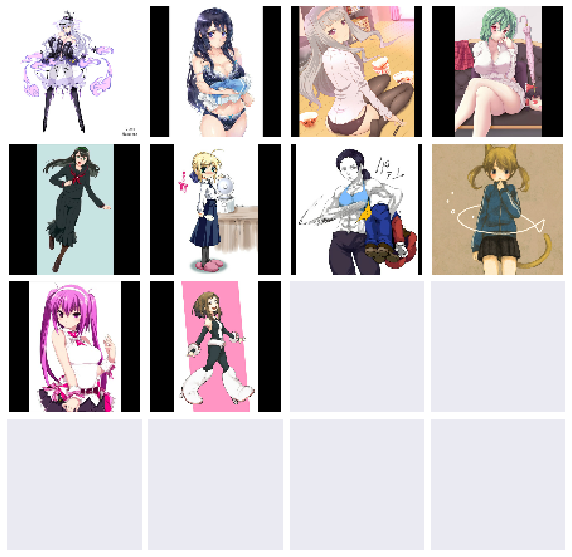

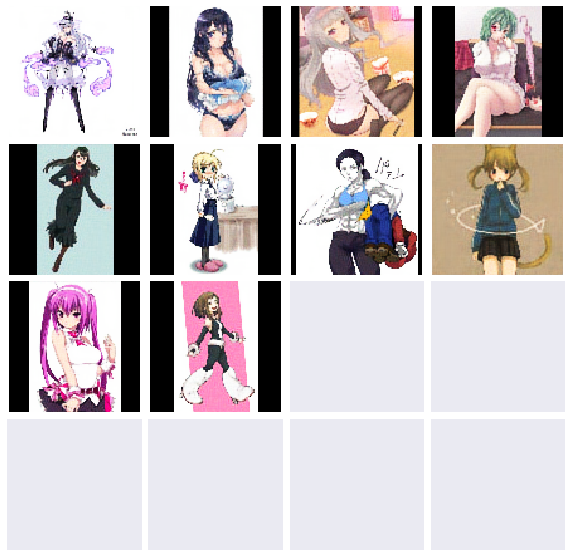

In [37]:
# Create reconstructions  
# get batch
test_batch = next(test_batch_generator)

# show the test images
show_images(test_batch, n_channels, resize_dim)

# create reconstructions
reconstructions = autoencoder.predict(test_batch)

# show the reconstructioned test images
show_images(reconstructions, n_channels, resize_dim)

## 4. Apply model to a real image

/home/peter/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


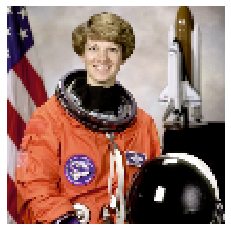

In [38]:
# grab an image
transfer_image = data.astronaut()

# resize the image and put it into gray scale
resized_transfer_image = transform_image(transfer_image, n_channels, resize_dim)

# batch it
reshaped_transfer_image = resized_transfer_image.reshape(-1, resize_dim, resize_dim, n_channels)

# display an image
show_image(resized_transfer_image, n_channels, resize_dim)

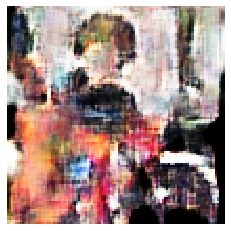

In [39]:
# run the image through the model
test_y = autoencoder.predict(reshaped_transfer_image)

# view the resulting image
show_image(test_y, n_channels, resize_dim)

# 5. Export model for production use

In [40]:
# export the trained model in TF.js Layers format
autoencoder.save(model_path)